<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_4/Lab_4/Ch13_ProbSolutions_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 13: Combining Methods: Ensembles and Uplift Modeling


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.

> Edited and presented by Dillon Orr for University of San Diego, 2022


In [2]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 2.2 MB/s 


In [3]:
# # Import required packages for this chapter

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


from dmba import classificationSummary

%matplotlib inline

no display found. Using non-interactive Agg backend


# Problem 13.4 - Hair Care Product - Uplift Modeling
This problem uses the data set in _Hair-Care-Product.csv_, courtesy of SAS. In this hypothetical case, a promotion for a hair care product was sent to some members of a buyers club.  Purchases were then recorded for both the members who got the promotion and those who did not.

## Preprocessing

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_4/Lab_4/Hair_Care_Product.csv')
df.head()

,Purchase,Age,Hair Color,U.S. Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1


In [6]:
df_copy = df.copy()

df_copy.columns = [d.replace(' ', '_').replace('.', '') for d in df_copy.columns]
df_copy.head()

,Purchase,Age,Hair_Color,US_Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1


## a. What is the purchase propensity... 

#### i. Among those who received the promotion? 
> The purchase propensity among those who received the promotion = (Number of purchases made) / (Total Number of Records)

The `Promotion_ord` column has a 1 for members that received a promotion. The `Purchase` column has a 1 for members that purchased a product after the promotion. 

In [7]:
# Number of members that received promotion
promotion_members = len(df_copy[df_copy['Promotion_ord'] == 1])
print("Total Number of Records", promotion_members)

# Number of purchases made for members that received promotion
promotion_purchases = sum(df_copy['Purchase'][df_copy['Promotion_ord'] == 1])
print("Number of purchases made", promotion_purchases)

# Purchase propensity for members who received promotion
promotion_propensity = promotion_purchases / promotion_members
print(f"{promotion_purchases} / {promotion_members} = {promotion_propensity}")

Total Number of Records 4976
Number of purchases made 80
80 / 4976 = 0.01607717041800643


#### i. Among those who did not receive the promotion? 

In [9]:
# Number of members that did not receive a promotion
non_promotion_members = len(df_copy[df_copy['Promotion_ord'] == 0])
print("Total Number of Records", non_promotion_members)

# Number of purchases made for members that did not receive a promotion
non_promotion_purchases = sum(df_copy['Purchase'][df_copy['Promotion_ord'] == 0])
print("Number of purchases made", non_promotion_purchases)

# # Purchase propensity for members who did not receive promotion
non_promotion_propensity = non_promotion_purchases / non_promotion_members
print(f"{non_promotion_purchases} / {non_promotion_members} = {non_promotion_propensity}")

Total Number of Records 5024
Number of purchases made 32
32 / 5024 = 0.006369426751592357


## b. Partition the data into training (60\%) and validation (40\%) and...

In [ ]:
# ensure hair color and region are typed as categorical variables
df_copy.Hair_Color = df_copy.Hair_Color.astype('category')
df_copy.US_Region = df_copy.US_Region.astype('category')

df_dummies = pd.get_dummies(df_copy, drop_first=True)
df_dummies.head()

,Purchase,Age,Validation,Promotion_ord,Gender_ord,Residence_ord,Hair_Color_Blond,Hair_Color_Brown,Hair_Color_Red,US_Region_Northwest,US_Region_Southeast,US_Region_Southwest
0,0,25,1,1,0,1,0,0,0,0,0,1
1,0,30,1,0,0,1,0,0,0,1,0,0
2,0,45,1,0,0,0,0,0,1,0,0,0
3,0,35,0,0,0,1,1,0,0,0,0,1
4,0,33,0,1,0,1,0,1,0,0,0,1


In [ ]:
# separate target and predictors
y = df_dummies['Purchase'].to_numpy()
X = df_dummies.drop(columns=['Purchase'])

# Standardize the dataset
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X * 1.0)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.4, random_state=1)

### i. Fit uplift using a Random Forest.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
classificationSummary(y_test, pred)

Confusion Matrix (Accuracy 0.9840)

       Prediction
Actual    0    1
     0 3936   12
     1   52    0


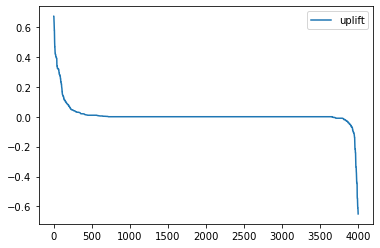

In [ ]:
uplift_df = pd.DataFrame(X_test, columns = df_dummies.drop(columns='Purchase').columns)

uplift_df.Promotion_ord = 1
pred_promotion = rf.predict_proba(uplift_df.values) # using .values because model was fitted without column names

uplift_df.Promotion_ord = 0
pred_none = rf.predict_proba(uplift_df.values)

rf_uplift = pd.DataFrame({
    'probMessage': pred_promotion[:,1],
    'probNoMessage': pred_none[:,1],
    'uplift': pred_promotion[:,1] - pred_none[:,1],
    }, index=uplift_df.index)

rf_uplift = rf_uplift.sort_values(by=['uplift'], ascending=False)

rf_uplift.reset_index().plot(x=None, y='uplift')
plt.show()

### ii. Uplift using $k$-NN.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
for r in range (1, 10): 
    knn = KNeighborsClassifier(n_neighbors=r)
    knn.fit(X_train, y_train)

    # print(knn.score(X_train, y_train))
    
    y_pred = knn.predict(X_test)
    
    print(f'neighbors: {r}')
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred, zero_division=0)}')
    print(f'recall: {recall_score(y_test, y_pred, zero_division=1)}')
    print('\n')
    
    

neighbors: 1
accuracy: 0.9745
precision: 0.037037037037037035
recall: 0.038461538461538464


neighbors: 2
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 3
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 4
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 5
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 6
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 7
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 8
accuracy: 0.987
precision: 0.0
recall: 0.0


neighbors: 9
accuracy: 0.987
precision: 0.0
recall: 0.0




In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
    
classificationSummary(y_test, pred)

Confusion Matrix (Accuracy 0.9745)

       Prediction
Actual    0    1
     0 3896   52
     1   50    2


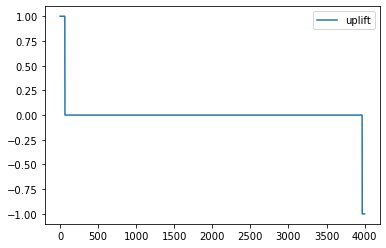

In [ ]:
uplift_df = pd.DataFrame(X_test, columns = df_dummies.drop(columns='Purchase').columns)

uplift_df.Promotion_ord = 1
pred_promotion = knn.predict_proba(uplift_df.values) # using .values because model was fitted without column names

uplift_df.Promotion_ord = 0
pred_none = knn.predict_proba(uplift_df.values)

knn_uplift = pd.DataFrame({
    'probMessage': pred_promotion[:,1],
    'probNoMessage': pred_none[:,1],
    'uplift': pred_promotion[:,1] - pred_none[:,1],
    }, index=uplift_df.index)

knn_uplift = knn_uplift.sort_values(by=['uplift'], ascending=False)

knn_uplift.reset_index().plot(x=None, y='uplift')
plt.show()

## c. Report the two models' recommendations for the first three members.

#### Random Forest

In [ ]:
rf_uplift.head(3)

,probMessage,probNoMessage,uplift
653,0.682,0.01,0.672
3883,0.682,0.01,0.672
1810,0.640,0.00,0.640


#### K Nearest Neighbors

In [ ]:
knn_uplift.head(3)

,probMessage,probNoMessage,uplift
3246,1.0,0.0,1.0
2227,1.0,0.0,1.0
3559,1.0,0.0,1.0


---

### (BONUS) With removal of variables and oversampling due to class imbalance

In [15]:
from imblearn.over_sampling import RandomOverSampler

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_4/Lab_4/Hair_Care_Product.csv')
df.head()

,Purchase,Age,Hair Color,U.S. Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1


In [13]:
df_copy = df.copy()
df_copy.columns = [d.replace(' ', '_').replace('.', '') for d in df_copy.columns]

# drop hair color and region
df_copy = df_copy.drop(columns=['Hair_Color', 'US_Region'])

df_dummies = pd.get_dummies(df_copy, drop_first=True)

df_dummies.head()

,Purchase,Age,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,1,1,0,1
1,0,30,1,0,0,1
2,0,45,1,0,0,0
3,0,35,0,0,0,1
4,0,33,0,1,0,1


In [16]:
# separate target and predictors
y = df_dummies['Purchase'].to_numpy()
X = df_dummies.drop(columns=['Purchase'])

# Standardize the dataset
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X * 1.0)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.4, random_state=1)

In [17]:
unique, counts = np.unique(y_train, return_counts=True)

class_frequency_counts = {
    unique[0]: counts[0],
    unique[1]: counts[1]
}

class_frequency_counts

{0: 5940, 1: 60}

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [ ]:
unique, counts = np.unique(y_train_over, return_counts=True)

oversampled_class_frequency_counts = {
    unique[0]: counts[0],
    unique[1]: counts[1]
}

oversampled_class_frequency_counts

{0: 5940, 1: 5940}

#### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_over, y_train_over)

pred = rf.predict(X_test)
classificationSummary(y_test, pred)

Confusion Matrix (Accuracy 0.8622)

       Prediction
Actual    0    1
     0 3441  507
     1   44    8


#### KNN

In [ ]:
for r in range (1, 25): 
    knn = KNeighborsClassifier(n_neighbors=r)
    knn.fit(X_train_over, y_train_over)

    # print(knn.score(X_train, y_train))
    
    y_pred = knn.predict(X_test)
    
    print(f'neighbors: {r}')
    
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred, zero_division=0)}')
    print(f'recall: {recall_score(y_test, y_pred, zero_division=1)}')
    print('\n')

neighbors: 1
accuracy: 0.985
precision: 0.0
recall: 0.0


neighbors: 2
accuracy: 0.98675
precision: 0.0
recall: 0.0


neighbors: 3
accuracy: 0.98675
precision: 0.0
recall: 0.0


neighbors: 4
accuracy: 0.98675
precision: 0.0
recall: 0.0


neighbors: 5
accuracy: 0.98525
precision: 0.0
recall: 0.0


neighbors: 6
accuracy: 0.98525
precision: 0.0
recall: 0.0


neighbors: 7
accuracy: 0.9835
precision: 0.0
recall: 0.0


neighbors: 8
accuracy: 0.98375
precision: 0.0
recall: 0.0


neighbors: 9
accuracy: 0.98075
precision: 0.0
recall: 0.0


neighbors: 10
accuracy: 0.98075
precision: 0.0
recall: 0.0


neighbors: 11
accuracy: 0.97975
precision: 0.03225806451612903
recall: 0.019230769230769232


neighbors: 12
accuracy: 0.97975
precision: 0.03225806451612903
recall: 0.019230769230769232


neighbors: 13
accuracy: 0.976
precision: 0.021739130434782608
recall: 0.019230769230769232


neighbors: 14
accuracy: 0.9775
precision: 0.025
recall: 0.019230769230769232


neighbors: 15
accuracy: 0.9705
precision: 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train_over, y_train_over)

pred = knn.predict(X_test)
classificationSummary(y_test, pred)

Confusion Matrix (Accuracy 0.8512)

       Prediction
Actual    0    1
     0 3395  553
     1   42   10
